<a href="https://colab.research.google.com/github/pratham-25/Sentiment_Analysis_Project/blob/master/test_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import zipfile

# !unzip /content/test.ft.zip
# !unzip /content/train.ft.zip

from google.colab import drive

# drive.mount('/content/gdrive')

In [ ]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
# device = torch.device("cuda")

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")  # Assigns the first available GPU
  print(f"Device assigned: {device}")
else:
  print("No GPU available, defaulting to CPU.")
  device = torch.device("cpu")

No GPU available, defaulting to CPU.


In [ ]:

# Get text and labels from raw file

def get_data(filepath):
    reviews = []
    text = []
    label = []
    with open(filepath,"r") as f:
        for line in f:
            # x = line.decode()
            x = line.partition("__label__")
            reviews.append(x[2:])
        pass
    f.close()
    for review in reviews:
        label.append(review[0].split()[0])
        label[-1] = '0' if label[-1] == '1' else '1'
        text.append(' '.join(review[0].split()[1:]))

    return text,label

In [ ]:
# Create dataframe

def createDataFrame(filepath):
    text,label = get_data(filepath)
    data = {"text":text,"label":label}
    df = pd.DataFrame(data)
    print("Number of records:",len(df))
    df.dropna(inplace=True) # remove null records
    df.reset_index(drop=True,inplace=True)
    df["label"] = df["label"].astype(int)
    print("Number of records after removing nulls:",len(df))

    return df

In [ ]:
train = createDataFrame('/content/train.ft.txt')

Number of records: 401854
Number of records after removing nulls: 401854


In [ ]:
train.head()

,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [ ]:
test = createDataFrame('/content/test.ft.txt')

Number of records: 400000
Number of records after removing nulls: 400000


In [ ]:
test.head()

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [ ]:
train.head()

,text,label
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


In [ ]:
test.head()

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,2
1,One of the best game music soundtracks - for a...,2
2,Batteries died within a year ...: I bought thi...,1
3,"works fine, but Maha Energy is better: Check o...",2
4,Great for the non-audiophile: Reviewed quite a...,2


In [ ]:
print(train.shape)
print(test.shape)

(401854, 2)
(400000, 2)


In [ ]:
train['label'].value_counts(normalize=True)

1    0.505091
0    0.494909
Name: label, dtype: float64

In [ ]:
# Splitting dataset into train, test, val

from sklearn.model_selection import train_test_split

test_label = test['label']
test_text = test['text']

val_text, train_text, val_labels, train_labels = train_test_split(train['text'], train['label'],
                                                                random_state=2018,
                                                                test_size=0.1,
                                                                stratify=train['label'])

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'No. of Messages')

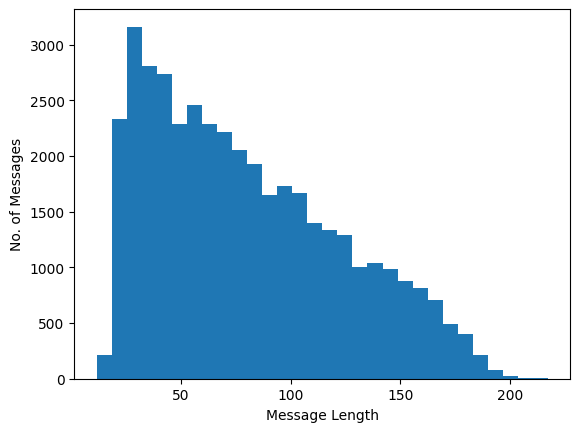

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

seq_len = pd.Series(seq_len)
plt.hist(seq_len, bins = 30)
plt.xlabel('Message Length')
plt.ylabel('No. of Messages')


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 175,
    pad_to_max_length=True,
    truncation=True
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 175,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 175,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
tokens_train.keys()

In [ ]:
def chkList(lst):
  return len(set(lst)) == 1

In [ ]:
myList = list(map(len, tokens_val['input_ids']))

if chkList(myList) == True:
    print("Equal")
else:
    print("Not Equal")

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [ ]:
## convert lists to tensors

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [ ]:
## convert lists to tensors

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:
len(train_dataloader)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        # torch.cuda.set_device(self.opt.gpu_ids[-1])
        # torch._C._cuda_setDevice(-1)

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)

print("Class Weights:",class_weights)

In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        print(f"Sent ID data type: {sent_id.dtype}, shape: {sent_id.shape}")
        print(f"Mask data type: {mask.dtype}, shape: {mask.shape}")
        print(f"Labels data type: {labels.dtype}, shape: {labels.shape}")
        print("Labels max: ", max(labels), " Labels min: ", min(labels))


        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            # elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        print(f"Sent ID data type: {sent_id.dtype}, shape: {sent_id.shape}")
        print(f"Mask data type: {mask.dtype}, shape: {mask.shape}")
        print(f"Labels data type: {labels.dtype}, shape: {labels.shape}")
        print("Labels max: ", max(labels), " Labels min: ", min(labels))

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
if torch.cuda.is_available():
  print("GPU is available!")
else:
  print("GPU is not available.")

device_count = torch.cuda.device_count()
print(f"Number of available GPU devices: {device_count}")

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 1

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')